# Импорт библиотек

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms as tfs
import tqdm

# Работа с датасетом MNIST

In [2]:
class MNISTSegmentationDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.mnist = torchvision.datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, index):
        image, label = self.mnist[index]

        segmentation_mask = torch.full((image.shape[1], image.shape[2]), 10, dtype=torch.long)

        digit_pixels = image[0] > 0.1

        segmentation_mask[digit_pixels] = label

        return image, segmentation_mask

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNISTSegmentationDataset(train=True, transform=transform)
test_dataset = MNISTSegmentationDataset(train=False, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]


In [4]:
def visualize_segmentation(dataset, num_examples):

    cmap = plt.colormaps['tab20'].resampled(11)

    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 4*num_examples))

    if num_examples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_examples):
        idx = random.randint(0, len(dataset) - 1)
        image, segmentation_mask = dataset[idx]

        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Класс: {torch.mode(segmentation_mask[segmentation_mask != 10]).values.item()}')
        axes[i, 0].axis('off')

        seg_display = axes[i, 1].imshow(segmentation_mask.numpy(), cmap=cmap, vmin=0, vmax=10)
        axes[i, 1].set_title('Маска сегментации')
        axes[i, 1].axis('off')

        plt.colorbar(seg_display, ax=axes[i, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

Несколько примеров из тренировчного набора:


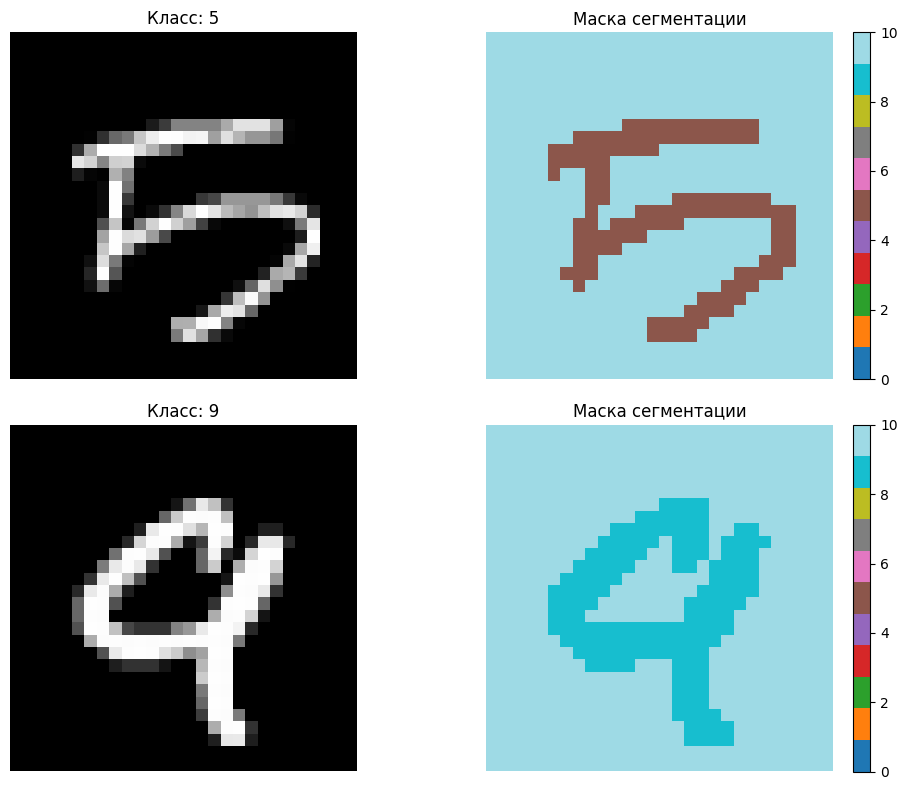

In [5]:
print("Несколько примеров из тренировчного набора:")
visualize_segmentation(train_dataset, num_examples=2)

Несколько примеров из тестового набора:


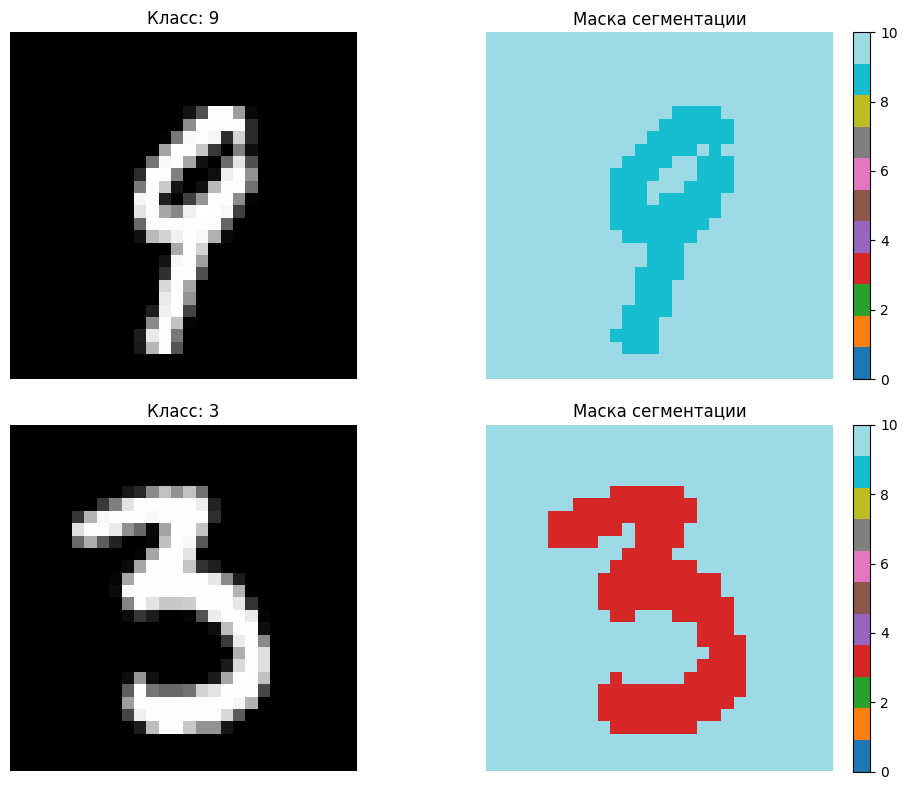

In [6]:
print("Несколько примеров из тестового набора:")
visualize_segmentation(test_dataset, num_examples=2)

# Создание датасета с 1-4 цифрами на одном изображении на основе датасета MNIST

In [24]:
class MNISTSegmentationMultiDataset(Dataset):
    def __init__(self, base_dataset, num_samples=10000, max_digits=4, image_size=64, seed=42):
        self.base_dataset = base_dataset
        self.num_samples = num_samples
        self.max_digits = max_digits
        self.image_size = image_size
        self.seed = seed

        self.data = []
        self.generate_data()

    def generate_data(self):
        random.seed(self.seed)
        torch.manual_seed(self.seed)

        for i in tqdm.tqdm(range(self.num_samples), desc="Создание датасета"):
            self.data.append(self.generate_sample())

    def generate_sample(self):
        num_digits = random.randint(1, self.max_digits)

        composite_image = torch.zeros(1, self.image_size, self.image_size)
        composite_mask = torch.full((self.image_size, self.image_size), 10, dtype=torch.long)

        placed_boxes = []

        for _ in range(num_digits):
            digit_index = random.randint(0, len(self.base_dataset) - 1)
            digit_image, digit_mask = self.base_dataset[digit_index]

            non_zero = (digit_mask != 10).nonzero(as_tuple=True)
            if len(non_zero[0]) == 0:
                continue

            min_y, min_x = non_zero[0].min(), non_zero[1].min()
            max_y, max_x = non_zero[0].max(), non_zero[1].max()

            digit_height = max_y - min_y + 1
            digit_width = max_x - min_x + 1

            placed = False
            attempts = 0
            while not placed and attempts < 100:
                pos_y = random.randint(0, self.image_size - digit_height - 1)
                pos_x = random.randint(0, self.image_size - digit_width - 1)

                new_box = (pos_x, pos_y, pos_x + digit_width, pos_y + digit_height)

                overlaps = False
                for box in placed_boxes:
                    if self.boxes_overlap(new_box, box):
                        overlaps = True
                        break

                if not overlaps:
                    digit_region = digit_image[0, min_y:max_y+1, min_x:max_x+1]
                    mask_region = digit_mask[min_y:max_y+1, min_x:max_x+1]

                    composite_image[0, pos_y:pos_y+digit_height, pos_x:pos_x+digit_width] = digit_region

                    digit_pixels = mask_region != 10
                    composite_mask[pos_y:pos_y+digit_height, pos_x:pos_x+digit_width][digit_pixels] = mask_region[digit_pixels]

                    placed_boxes.append(new_box)
                    placed = True

                attempts += 1

        return composite_image, composite_mask

    def boxes_overlap(self, box1, box2, margin=2):
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2

        x1_min -= margin; y1_min -= margin
        x1_max += margin; y1_max += margin
        x2_min -= margin; y2_min -= margin
        x2_max += margin; y2_max += margin

        return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [25]:
multi_train_dataset = MNISTSegmentationMultiDataset(train_dataset, num_samples=50000, image_size=64)
multi_test_dataset = MNISTSegmentationMultiDataset(test_dataset, num_samples=10000, image_size=64)

Создание датасета: 100%|██████████| 10000/10000 [01:07<00:00, 147.50it/s]


# Анализ и сохранение полученного датасета

In [26]:
def visualize_multi_digit(dataset, num_examples):

    cmap = plt.colormaps['tab20'].resampled(11)

    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 5*num_examples))

    for i in range(num_examples):
        index = random.randint(0, len(dataset) - 1)
        image, segmentation_mask = dataset[index]

        axes[i, 0].imshow(image.squeeze(), cmap='gray')

        unique_digits = torch.unique(segmentation_mask)
        digits_present = [str(d.item()) for d in unique_digits if d < 10]
        axes[i, 0].set_title(f'Цифры: {", ".join(digits_present)}')
        axes[i, 0].axis('off')
        seg_display = axes[i, 1].imshow(segmentation_mask.numpy(), cmap=cmap, vmin=0, vmax=10)
        axes[i, 1].set_title('Маска сегментации')
        axes[i, 1].axis('off')
        plt.colorbar(seg_display, ax=axes[i, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

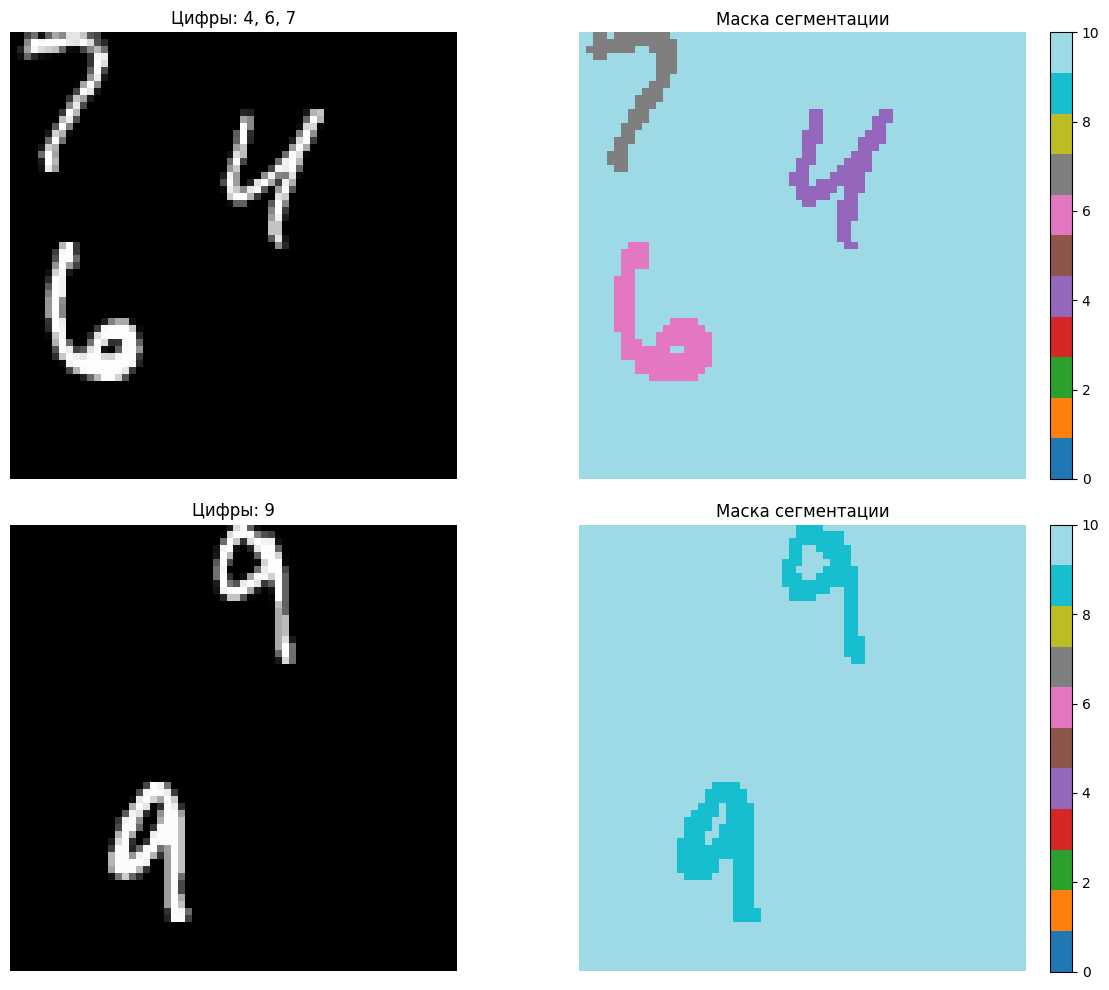

In [28]:
visualize_multi_digit(multi_train_dataset, num_examples=2)

In [36]:
def analyze_dataset(dataset):
    digit_counts = torch.zeros(10)
    num_digits_count = torch.zeros(4, dtype=int)

    print(f"Размер датасета: {len(dataset)}")

    # Используем range вместо прямого перебора датасета
    for index in tqdm.tqdm(range(len(dataset)), desc="Анализ датасета"):
        image, mask = dataset[index]
        unique_digits = torch.unique(mask)
        digits = unique_digits[unique_digits < 10]
        digit_counts[digits] += 1
        num_digits_count[len(digits)-1] += 1

    print(f"Итого: {digit_counts.sum().item()} цифр на {len(dataset)} изображений")
    print(f"Распределение по количеству цифр: \n1 цифра: {num_digits_count[0]} \n2 цифры: {num_digits_count[1]} \n3 цифры: {num_digits_count[2]} \n4 цифры: {num_digits_count[3]}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(10), digit_counts.numpy())
    plt.title('Частота цифр')
    plt.xlabel('Цифра')
    plt.ylabel('Количество')

    plt.subplot(1, 2, 2)
    plt.bar(range(1, 5), num_digits_count.numpy())
    plt.title('Количество цифр на изображении')
    plt.xlabel('Число цифр')
    plt.ylabel('Количество изображений')

    plt.tight_layout()
    plt.show()

    return digit_counts, num_digits_count

Размер датасета: 50000


Анализ датасета: 100%|██████████| 50000/50000 [00:10<00:00, 4827.51it/s]


Итого: 98592.0 цифр на 50000 изображений
Распределение по количеству цифр: 
1 цифра: 15520 
2 цифры: 21545 
3 цифры: 11758 
4 цифры: 1177


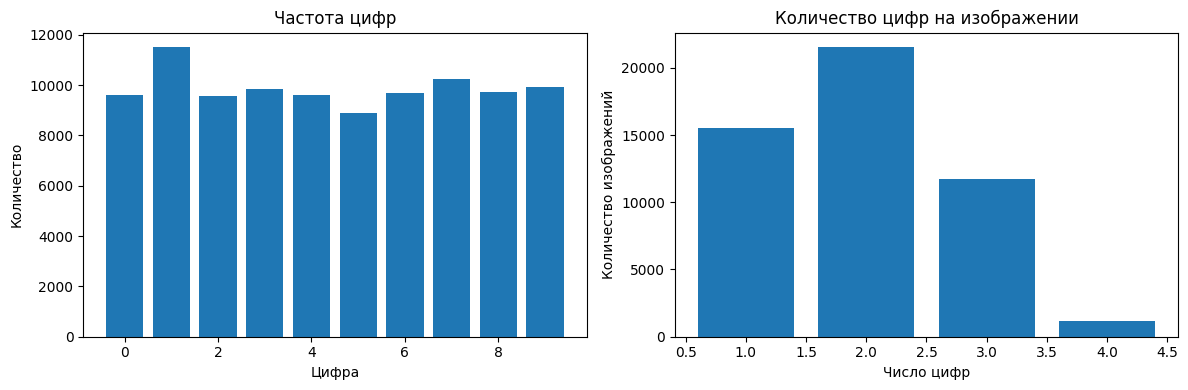

Размер датасета: 10000


Анализ датасета: 100%|██████████| 10000/10000 [00:01<00:00, 5337.12it/s]


Итого: 19734.0 цифр на 10000 изображений
Распределение по количеству цифр: 
1 цифра: 3154 
2 цифры: 4210 
3 цифры: 2384 
4 цифры: 252


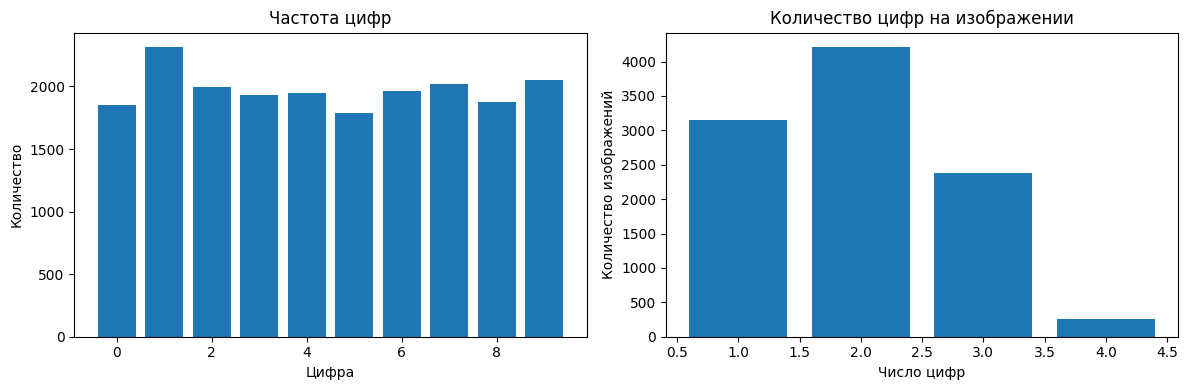

(tensor([1849., 2315., 1999., 1934., 1949., 1784., 1961., 2023., 1872., 2048.]),
 tensor([3154, 4210, 2384,  252]))

In [37]:
analyze_dataset(multi_train_dataset)
analyze_dataset(multi_test_dataset)

In [41]:
def save_dataset_pt(dataset, filename):

    torch.save(dataset.data, filename)
    print(f"Датасет сохранен в {filename}")


In [43]:
save_dataset_pt(multi_train_dataset, 'multi_train_dataset.pt')
save_dataset_pt(multi_test_dataset, 'multi_test_dataset.pt')

Датасет сохранен в multi_train_dataset.pt
Датасет сохранен в multi_test_dataset.pt
